In [1]:
from icevision.all import *

/root/miniforge-pypy3/envs/icevision/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


## Load Annotations

In [2]:
parser = parsers.VOCBBoxParser(annotations_dir='pascal_voc_annotations/', 
                               images_dir='/workspace/yolo_v8_training/oiv7_full/validation/')

In [3]:
# Parse annotations to create records
train_records, valid_records = parser.parse() # Defaults to 80:20 split
parser.class_map

  0%|          | 0/13318 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/13318 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 1366cde3b480a15c) - Clipping bbox ymax from 3793 to image height 2432 (Before: <BBox (xmin:393, ymin:1678, xmax:2318, ymax:3793)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 1366cde3b480a15c) - Clipping bbox ymax from 4320 to image height 2432 (Before: <BBox (xmin:1892, ymin:3530, xmax:2432, ymax:4320)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-FAIL - (record_id: 1366cde3b480a15c) - Cannot auto-fix coordinates: <BBox (xmin:1892, ymin:3530, xmax:2432, ymax:2432)>
	y_min:3530 is greater than or equal to y_max:2432 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: 1366cde3b480a15c) Removed annotation with index: 1, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:45


<ClassMap: {'background': 0, 'person': 1}>

In [4]:
image_size = 480
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=640), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [5]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [6]:
print(f"Train on {len(train_ds)} images")
print(f"Validate on {len(valid_ds)} images")

Train on 10654 images
Validate on 2664 images


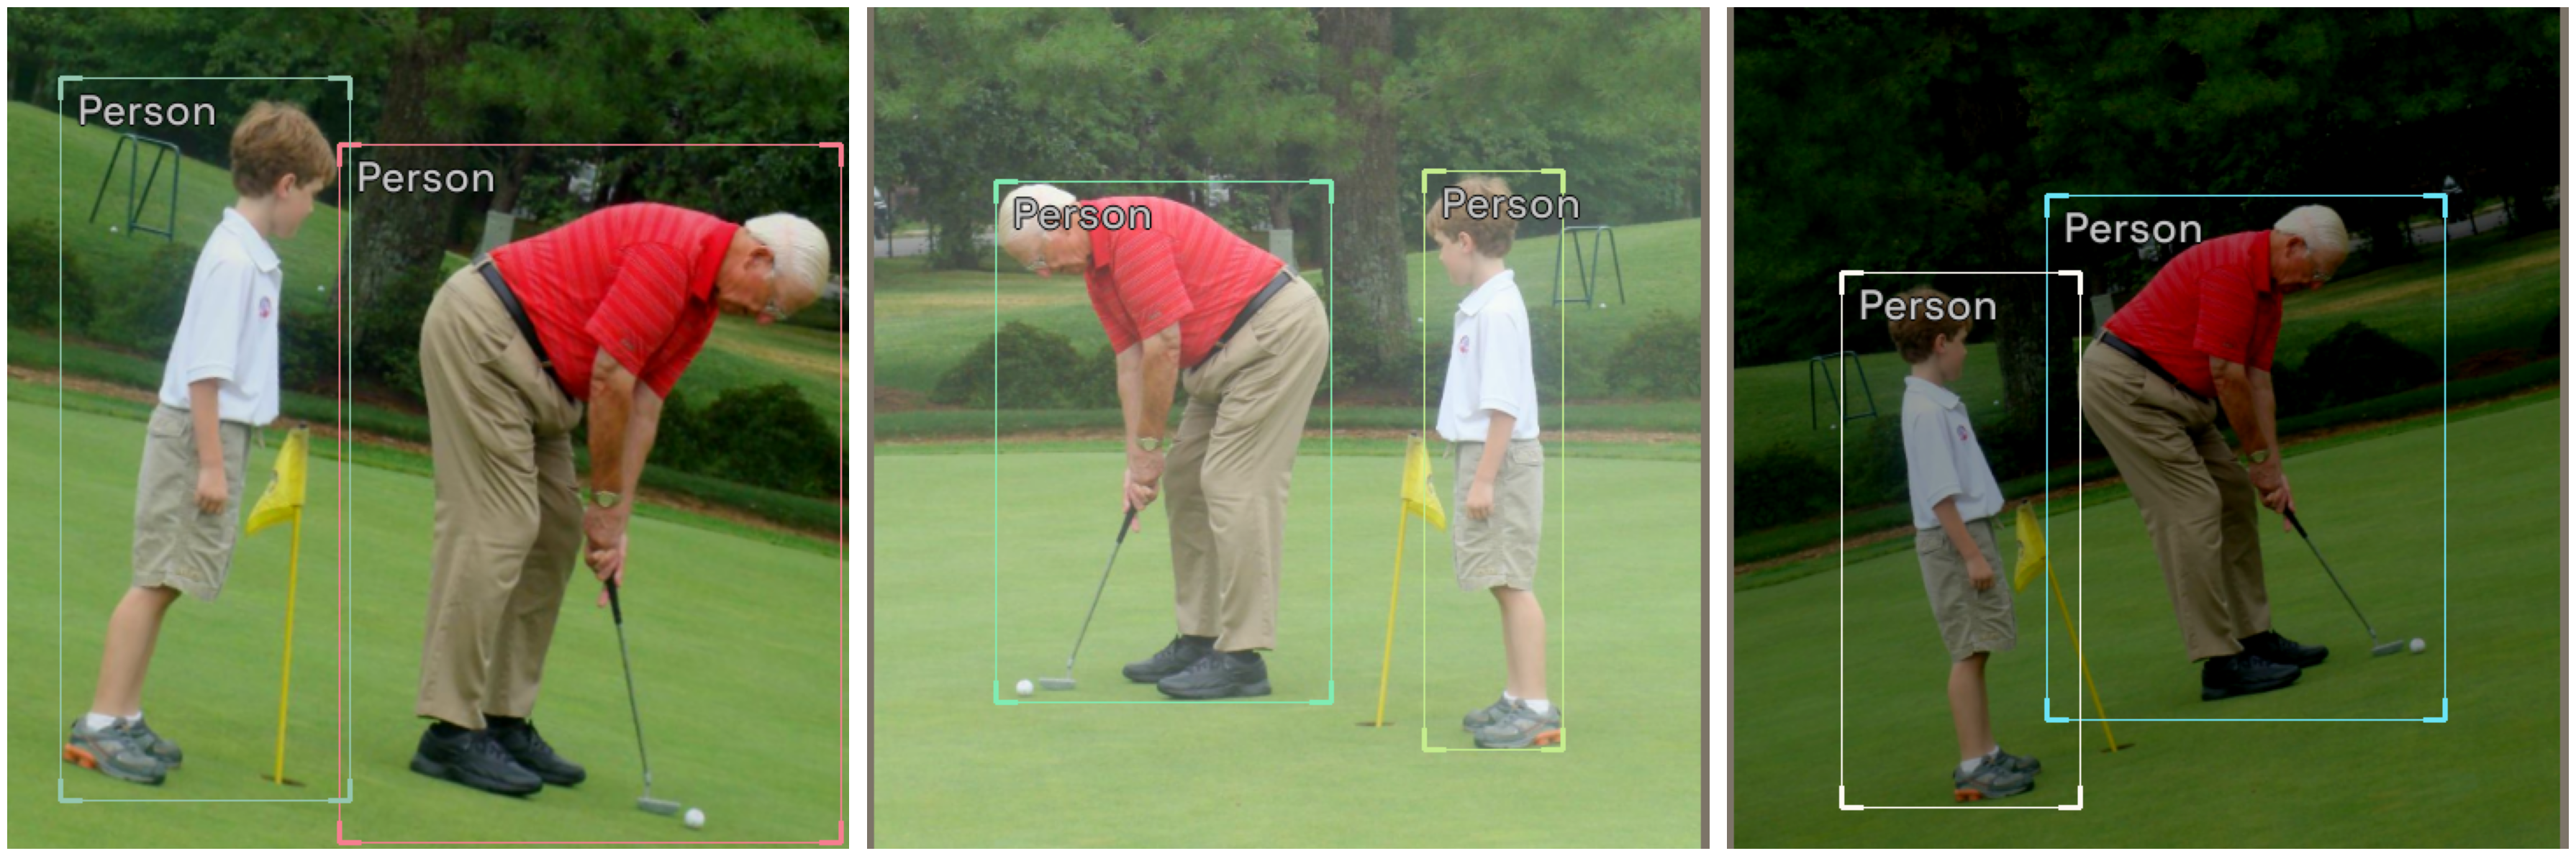

In [9]:
%matplotlib inline
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Build Model

In [10]:
model_type = models.mmdet.vfnet
backbone = model_type.backbones.resnet50_fpn_mstrain_2x
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

  0%|          | 0/131902412 [00:00<?, ?B/s]

2024-03-28 05:57:29,536 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2024-03-28 05:57:29,537 - mmcv - INFO - load model from: torchvision://resnet50
2024-03-28 05:57:29,538 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.3MB/s]
2024-03-28 05:57:31,711 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-03-28 05:57:31,723 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2024-03-28 05:57:31,751 - mmcv - INFO - initialize VFNetHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'vfnet_cls', 'std': 0.01, 'bias_prob': 0.01}

load checkpoint from local path: checkpoints/vfnet/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).


In [11]:
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=16, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=16, shuffle=False)

In [12]:
# model_type.show_batch(first(valid_dl), ncols=4)

In [13]:
from fastai.callback.tracker import SaveModelCallback, ShowGraphCallback

In [14]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], 
                                  model=model, 
                                  metrics=metrics,
                                  cbs=[ShowGraphCallback()])

/root/miniforge-pypy3/envs/icevision/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SuggestedLRs(valley=0.0003981071640737355)

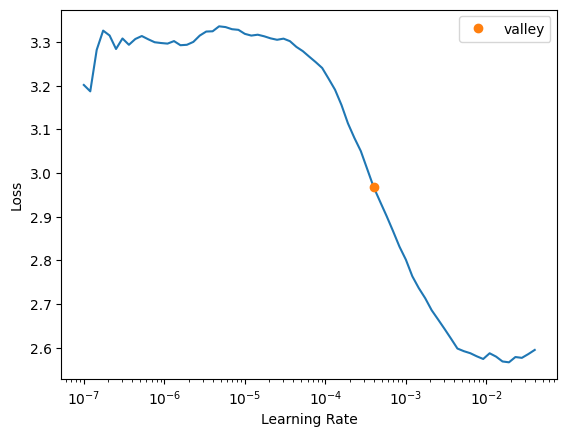

In [15]:
learn.lr_find()

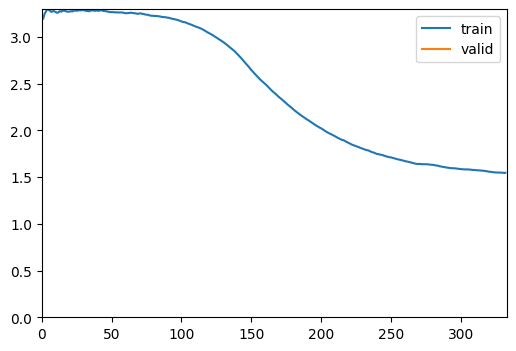

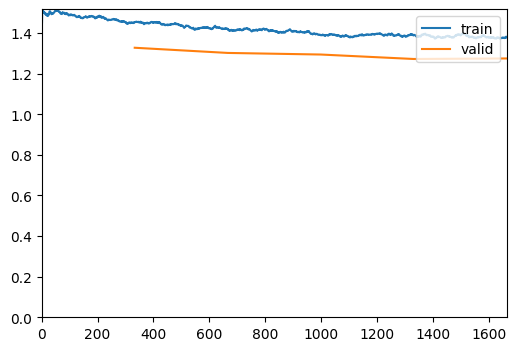

In [16]:
learn.fine_tune(5, 3e-5, freeze_epochs=1)

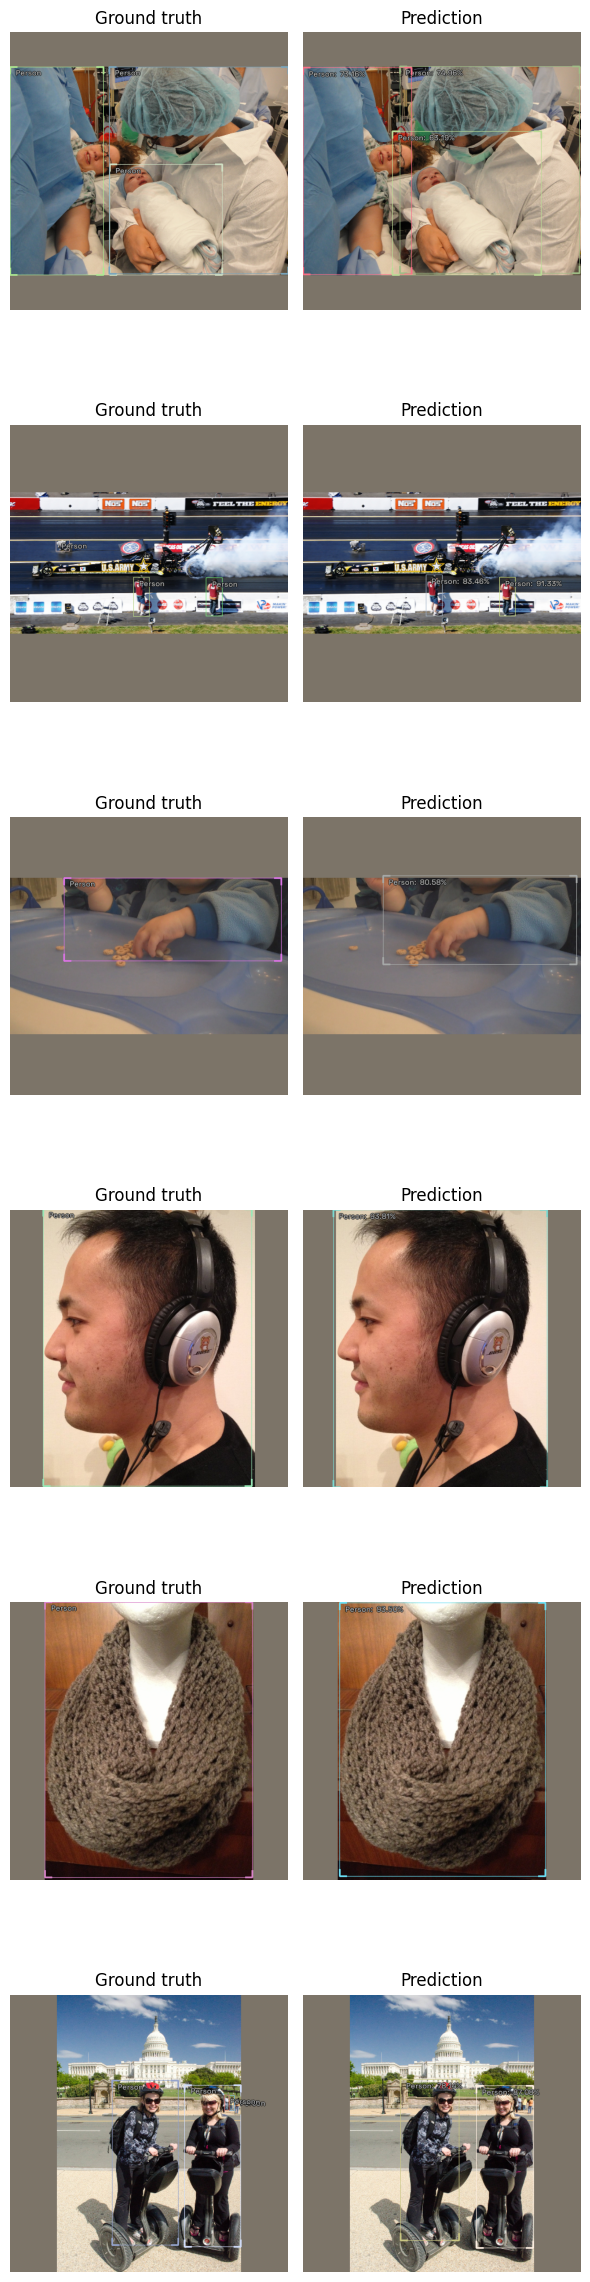

In [17]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

INFO     - Losses returned by model: ['loss_cls', 'loss_bbox'] | icevision.models.interpretation:plot_top_losses:219


  0%|          | 0/2664 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

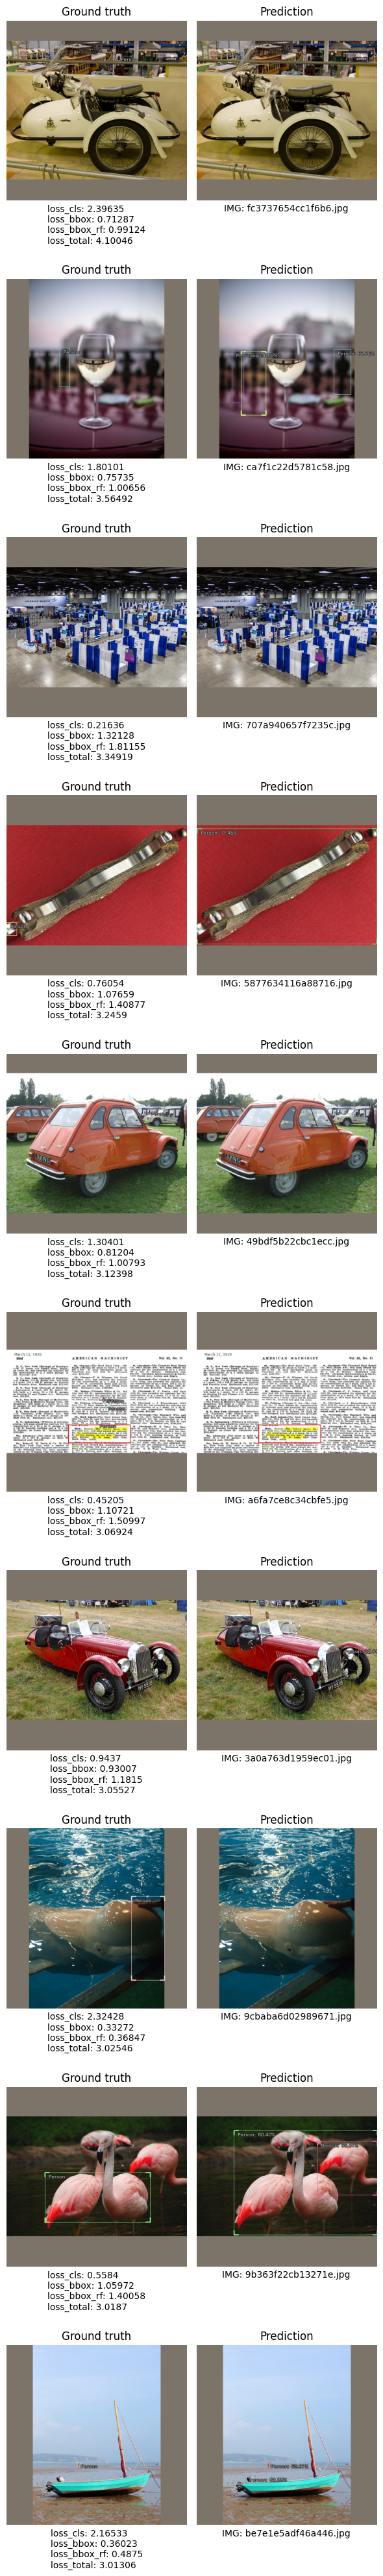

In [25]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="loss_total", n_samples=10, batch_size=32)

In [26]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=8)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

  0%|          | 0/333 [00:00<?, ?it/s]

In [ ]:
from icevision.models.checkpoint import *
save_icevision_checkpoint(model,
                        model_name='mmdet.vfnet', 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        img_size=640,
                        classes=parser.class_map.get_classes(),
                        filename='./models/model_checkpoint.pth',
                        meta={'icevision_version': 'master'})